# import packages

In [9]:
import os
import pandas as pd
import random
import time
import shutil
import requests
import matplotlib.pyplot as plt
from pygbif import occurrences as occ
from pygbif import species 
from PIL import Image
import numpy as np
from typing_extensions import Counter

# Initialize function to scrape images from Inaturalist

In [23]:
# Scrape Images and Metadata

# Here we make a function to save photos of a target species locally and save necessary metada: latitude, longitude, observation ID, photo IDs, Photo urls. Metadata is saved as a dictionary and photos are saved in a directory specified by the user.
# Metadata example:
# observation_id   latitude  longitude  observation_date  photo_ids  \
# 0       259323505  57.736160  10.629406 date  [465488543]
# 1       259193935  48.037273  11.509971 date  [465220887]
# 2       258982331  49.385485  19.790977 date  [464790765]
# 3       258835093  46.517517   9.908752 date  [464493974]
# 4       258811645  52.674268   6.516881 date  [464445739]
#
#                                               photos
# 0  [https://inaturalist-open-data.s3.amazonaws.co...
# 1  [https://inaturalist-open-data.s3.amazonaws.co...
# 2  [https://static.inaturalist.org/photos/4647907...
# 3  [https://static.inaturalist.org/photos/4644939...
# 4  [https://static.inaturalist.org/photos/4644457...

# Parameters
# --- Parameters ---
# Note: GBIF requires the Taxon Key (a numeric ID), not the species name string,
output_dir = "/mnt/c/Users/pdeschepper/Desktop/Vipera_aspis_gbif_export/"
record_limiter = 10
# GBIF occ.search() default limit is 200, max is 100,000 for a single search, 
# but we will manually loop for pagination.
PAGE_LIMIT = 200


def get_gbif_taxon_key(species_name):
    """Looks up the GBIF Taxon Key (usageKey) for a given scientific name."""
    result = species.name_backbone(scientificName=species_name, taxonRank="SPECIES")
    return result["usage"]["key"]

def scrape_gbif_images(species_name):
    """Scrape images and metadata for a target species from GBIF."""
    
    # 1. Get the Taxon Key
    taxon_key = get_gbif_taxon_key(species_name)
    if not taxon_key:
        print(f"❌ Could not find a GBIF Taxon Key for '{species_name}'. Aborting.")
        return []

    print(f"Found GBIF Taxon Key: {taxon_key}")
    
    # 2. Setup File System
    if os.path.exists(output_dir) and os.listdir(output_dir):
        # Clear existing image/csv files
        for file in os.listdir(output_dir):
            if file.endswith((".jpg", ".csv")):
                 os.remove(os.path.join(output_dir, file))
    else:
        os.makedirs(output_dir, exist_ok=True)


    # 3. Fetch Observations (Paginated Loop)
    observations = []
    offset = 0
    total_records_retrieved = 0

    while total_records_retrieved < record_limiter:
        print(f"Fetching records starting at offset {offset}...")
        try:
            # GBIF API search parameters
            response = occ.search(
                taxonKey=taxon_key,
                hasCoordinate=True,          # Must have coordinates
                hasGeospatialIssue=False,    # Should have no spatial issues
                mediaType='StillImage',      # Must have image/multimedia data
                limit=min(PAGE_LIMIT, record_limiter - total_records_retrieved),
                offset=offset
            )
        
        except Exception as e:
            print(f"An error occurred during GBIF API call: {e}")
            break

        current_results = response.get('results', [])

        if not current_results:
            print("Reached the end of available records or results are empty.")
            break

        observations.extend(current_results)
        
        total_records_retrieved = len(observations)
        print(f"  -> Collected {total_records_retrieved} of {record_limiter} so far.")

        # Check for exit conditions
        if response.get('endOfRecords') or total_records_retrieved >= record_limiter:
            break

        # Increment offset for next iteration
        offset += PAGE_LIMIT
        
        # Add a delay between API calls to be polite
        time.sleep(1)


    # 4. Process Observations, Download Images, and Store Metadata
    metadata = []
    s = requests.Session() 
    
    for obs in observations[:record_limiter]: # Limit to max requested
        
        # Core Metadata fields
        occurrence_id = obs.get('gbifID', None)
        latitude = obs.get('decimalLatitude', None)
        longitude = obs.get('decimalLongitude', None)
        # 🌟 GBIF date field is typically 'eventDate'
        observation_date = obs.get('eventDate', None) 
        
        # Multimedia is a list of dictionaries
        multimedia = obs.get('media', []) 
        
        photo_urls = []
        photo_ids = []

        # Download and save photos for this occurrence
        for media_item in multimedia:
            # GBIF uses 'identifier' for the original photo URL
            img_url = media_item.get('identifier', None)
            
            # Use a unique identifier for the filename. We use the original URL's hash 
            # or the media key if available, but for simplicity, let's use a combination
            # of the GBIF ID and an index, as a stable 'photo ID' is not guaranteed.
            # Using a simple index here is a compromise.
            photo_index = f"{occurrence_id}_{multimedia.index(media_item) + 1}"
            img_path = os.path.join(output_dir, f"{photo_index}.jpg")
            
            if not img_url:
                continue

            try:
                # Use the session for downloading
                img_response = s.get(img_url, timeout=10)
                img_response.raise_for_status()
                
                with open(img_path, 'wb') as f:
                    f.write(img_response.content)
                
                photo_urls.append(img_url)
                photo_ids.append(photo_index) # Store the filename ID

            except Exception as e:
                print(f"Error downloading media for {occurrence_id} from {img_url}: {e}")
                continue

        # Append metadata for the observation (only if images were successfully downloaded)
        if photo_urls:
             metadata.append({
                "gbif_id": occurrence_id,
                "latitude": latitude,
                "longitude": longitude,
                "observation_date": observation_date,
                "photo_ids": photo_ids,
                "photos": photo_urls
            })
            
    # 5. Save Metadata to CSV
    if metadata:
        df = pd.DataFrame(metadata)
        csv_path = os.path.join(output_dir, f"{species_name.replace(' ', '_')}_gbif_metadata.csv")
        df.to_csv(csv_path, index=False)
        print(f"\n✅ Successfully saved {len(metadata)} records and images to {output_dir}")
        print(f"✅ Metadata saved to: {csv_path}")
    else:
        print("⚠️ No records with images were successfully processed.")

    return metadata

# Use scraping function

In [25]:
# Usage
scrape_gbif_images("Vipera aspis")

Found GBIF Taxon Key: 2444339
Fetching records starting at offset 0...
  -> Collected 10 of 10 so far.

✅ Successfully saved 10 records and images to /mnt/c/Users/pdeschepper/Desktop/Vipera_aspis_gbif_export/
✅ Metadata saved to: /mnt/c/Users/pdeschepper/Desktop/Vipera_aspis_gbif_export/Vipera_aspis_gbif_metadata.csv


[{'gbif_id': '5063874331',
  'latitude': 47.154962,
  'longitude': -1.548729,
  'observation_date': '2025-02-04T13:30:42',
  'photo_ids': ['5063874331_1'],
  'photos': ['https://inaturalist-open-data.s3.amazonaws.com/photos/468094089/original.jpeg']},
 {'gbif_id': '5070120342',
  'latitude': 48.398854,
  'longitude': 2.580117,
  'observation_date': '2025-02-16T17:45:32',
  'photo_ids': ['5070120342_1', '5070120342_2', '5070120342_3'],
  'photos': ['https://inaturalist-open-data.s3.amazonaws.com/photos/470565723/original.jpg',
   'https://inaturalist-open-data.s3.amazonaws.com/photos/470565798/original.jpg',
   'https://inaturalist-open-data.s3.amazonaws.com/photos/470565837/original.jpg']},
 {'gbif_id': '5075001037',
  'latitude': 42.7,
  'longitude': -3.15,
  'observation_date': '2025-02-28',
  'photo_ids': ['5075001037_1'],
  'photos': ['https://observation.org/photos/111424208.jpg']},
 {'gbif_id': '5077152431',
  'latitude': 48.856019,
  'longitude': -1.573689,
  'observation_date':

# Open a photo and check size


Width: 1536, Height: 2048


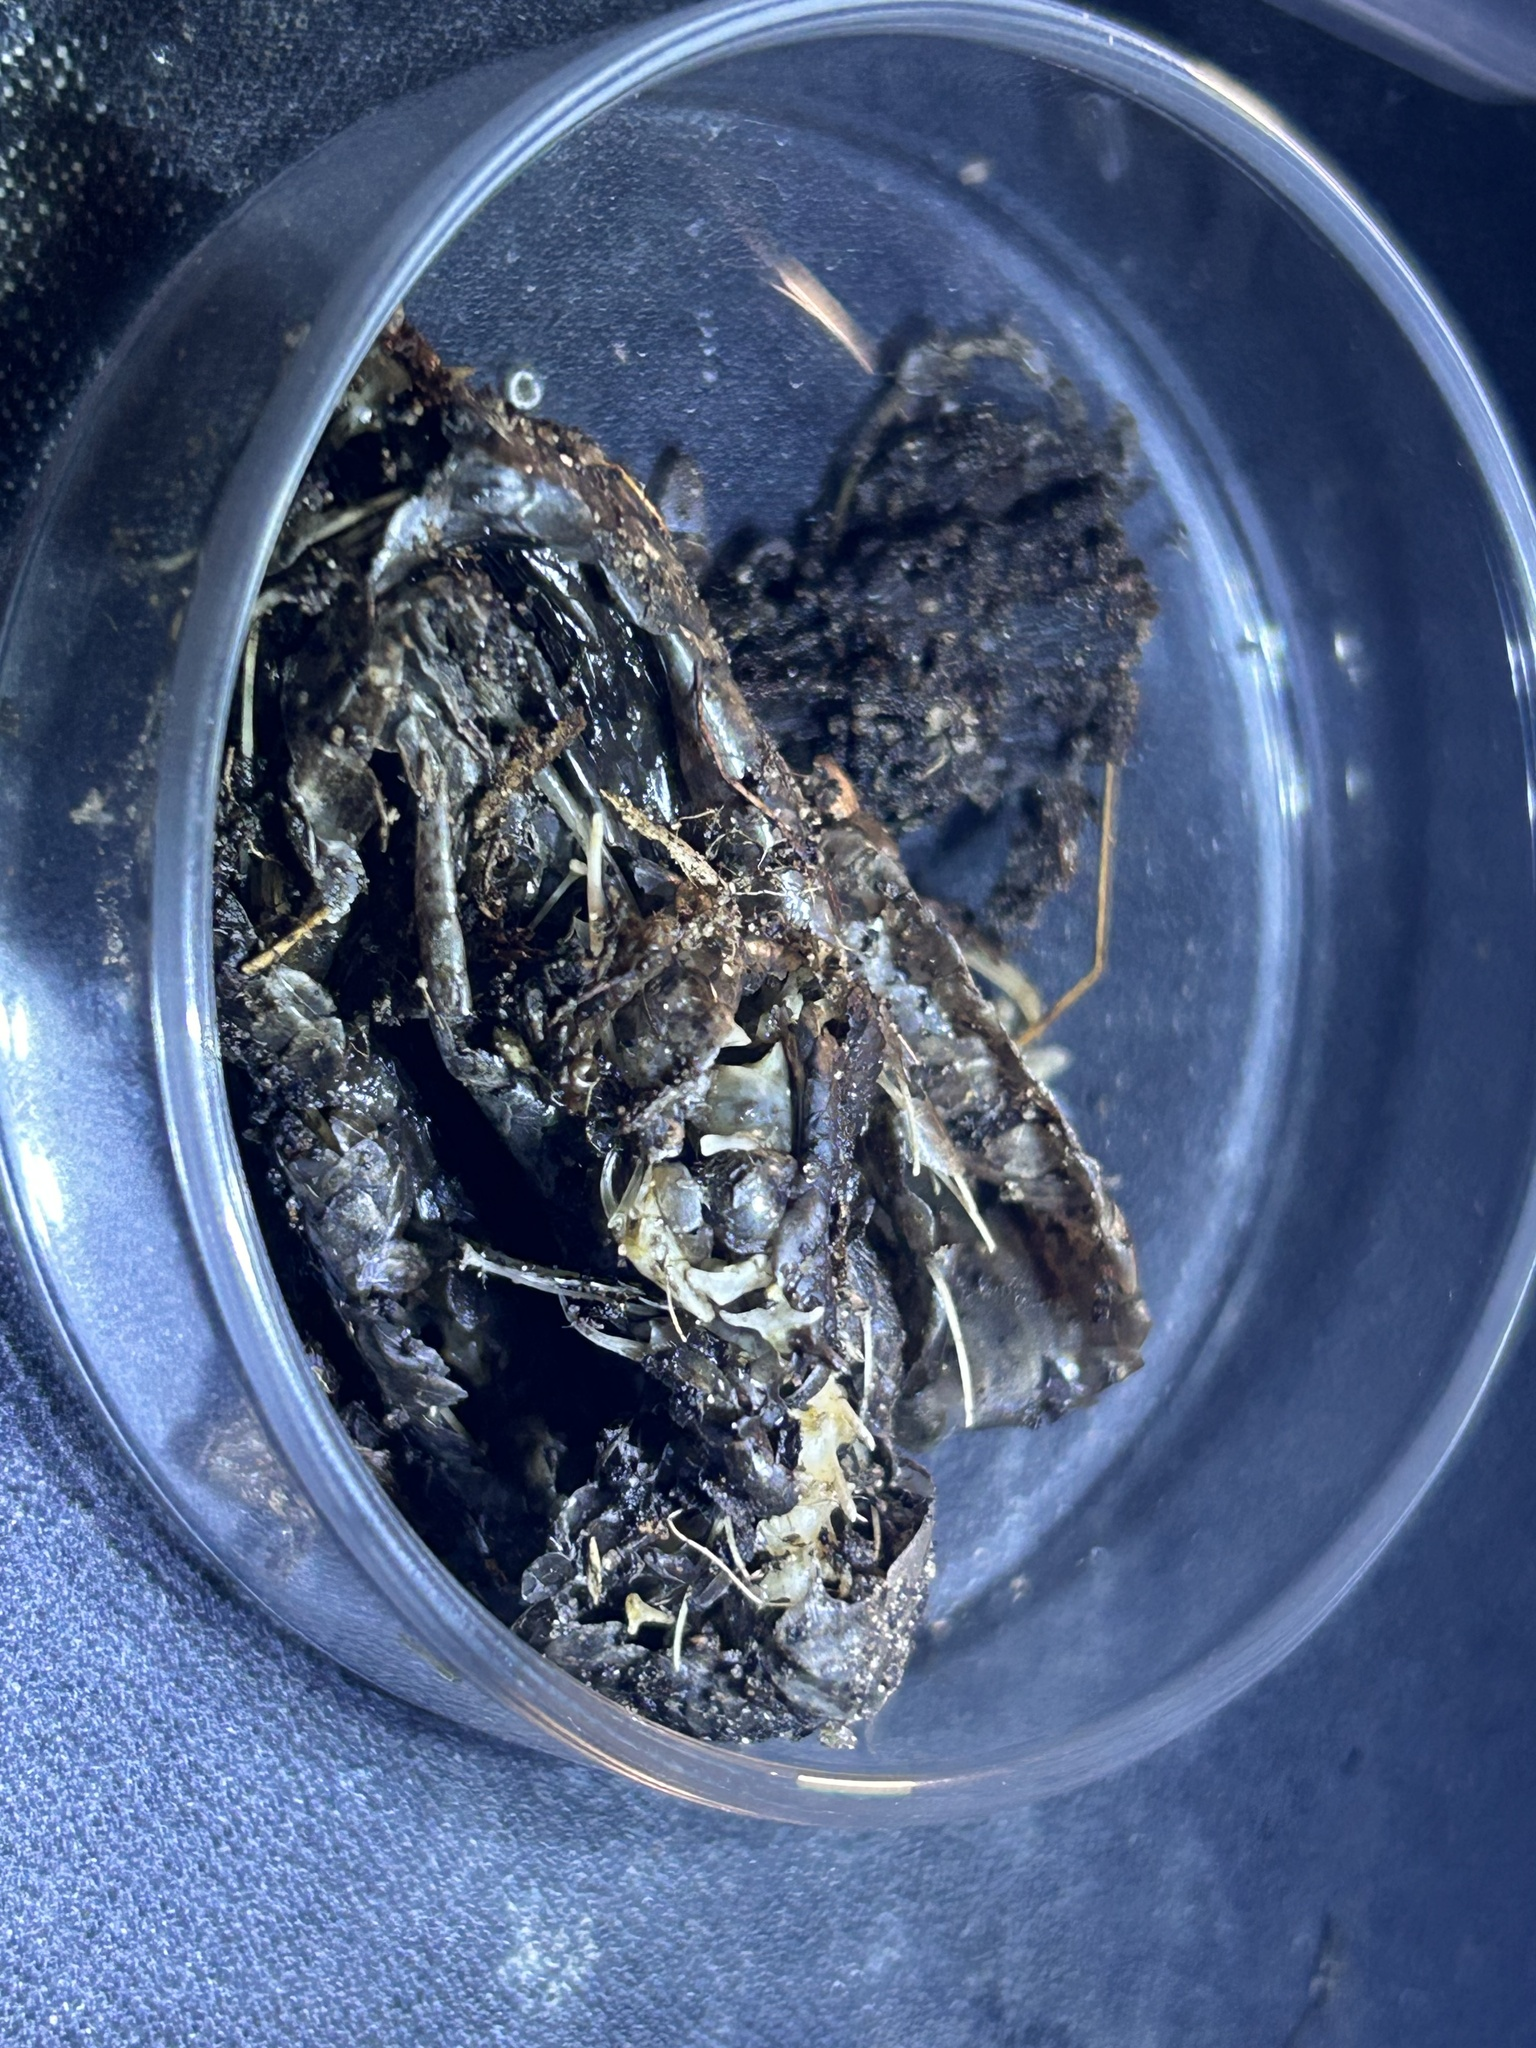

['5063874331_1.jpg', '5070120342_1.jpg', '5070120342_2.jpg', '5070120342_3.jpg', '5075001037_1.jpg', '5077152431_1.jpg', '5087318181_1.jpg', '5087318181_2.jpg', '5087382020_1.jpg', '5087382020_2.jpg', '5087382020_3.jpg', '5087487252_1.jpg', '5087527637_1.jpg', '5087534968_1.jpg', '5087534968_2.jpg', '5087534968_3.jpg', '5892482837_1.jpg', 'Vipera_aspis_gbif_metadata.csv']


In [26]:
# Get a list of all image files in the directory
image_files = []
for f in os.listdir(output_dir):
    if os.path.isfile(os.path.join(output_dir, f)):
        image_files.append(f)

# Select a random image file
random_image_file = random.choice(image_files)

# Construct the full path to the random image
random_image_path = os.path.join(output_dir, random_image_file)

# Open the random image
image = Image.open(random_image_path)

# Get dimensions
width, height = image.size
print(f"Width: {width}, Height: {height}")

# Display the image (optional)
display(image)

print(image_files)

# Zip photos (.jpg)

In [27]:
import os
import zipfile

def zip_jpg_files(output_directory, zip_file_name="images.zip"):
    """
    This function zips all the .jpg files in a given directory.

    Args:
        output_directory: The directory where the .jpg files are located.
        zip_file_name: The name of the zip file to be created (default: "images.zip").

    Returns:
        None. It creates a zip file in the output directory.
    """

    # Create the full path for the zip file
    zip_file_path = os.path.join(output_directory, zip_file_name)

    # Open the zip file in write mode ('w')
    with zipfile.ZipFile(zip_file_path, 'w') as zip_file:
        # Go through all the files and folders in the output directory
        for current_folder, subfolders, files in os.walk(output_directory):
            # Check each file in the current folder
            for file_name in files:
                # If the file ends with '.jpg', add it to the zip file
                if file_name.endswith('.jpg'):
                    # Get the full path of the file
                    file_path = os.path.join(current_folder, file_name)

                    # Add the file to the zip file using its original name
                    zip_file.write(file_path, arcname=file_name)

    # Print a message to confirm the zip file creation
    print(f"All .jpg files in '{output_directory}' have been zipped to '{zip_file_name}'")


# Call the zip function
zip_jpg_files(output_dir)

All .jpg files in '/mnt/c/Users/pdeschepper/Desktop/Vipera_aspis_gbif_export/' have been zipped to 'images.zip'
